## Validating regression models for prediction

In [1]:
import math
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline

#path = 'https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv'
NY_crime_2013 = pd.read_excel("table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls", header=None, skiprows=5)


To check that a model has good predictive validity, we will assess the performance of the model by first spliting into a test and train sets then we will use the same model on a separate data sets and compare if the performance indicators have similar values. A smaller difference would mean that the model has a good predictive validity. 


In [2]:
# Load the first data set and prepare for analysis 
NY_crime_2013.columns = ['City', 'Population', 'Violent', 'Murder', 'Rape_def1', 'Rape_def2', 'Robbery', 'Aggravated'
              , 'Property_crime', 'Burglary', 'Larceny', 'Motor_vehicle_teft', 'Arson']

In [3]:
# drop Rape_def1 as it contains no information, almost half of Arson variable is nan as well
NY_crime_2013 = NY_crime_2013.drop('Rape_def1', axis=1)
NY_crime_2013 = NY_crime_2013.drop('Arson', axis=1)

In [4]:
# replaceing NaN values with the median would be better than dropping them here
NY_crime_2013 = NY_crime_2013.fillna(NY_crime_2013.median())

In [5]:
# Change Robbery and Murder to categorical variables 
NY_crime_2013['Robbery'] = (NY_crime_2013['Robbery'] > 0).astype(int)
NY_crime_2013['Murder'] = (NY_crime_2013['Murder'] > 0).astype(int)

In [6]:
# add a feature 
NY_crime_2013['Population_sq'] = (NY_crime_2013['Population'] * NY_crime_2013['Population'])

In [7]:
NY_crime_2013.head()

,City,Population,Violent,Murder,Rape_def2,Robbery,Aggravated,Property_crime,Burglary,Larceny,Motor_vehicle_teft,Population_sq
0,Adams Village,1861.0,0.0,0,0.0,0,0.0,12.0,2.0,10.0,0.0,3.463321e+06
1,Addison Town and Village,2577.0,3.0,0,0.0,0,3.0,24.0,3.0,20.0,1.0,6.640929e+06
2,Akron Village,2846.0,3.0,0,0.0,0,3.0,16.0,1.0,15.0,0.0,8.099716e+06
3,Albany,97956.0,791.0,1,30.0,1,526.0,4090.0,705.0,3243.0,142.0,9.595378e+09
4,Albion Village,6388.0,23.0,0,3.0,1,16.0,223.0,53.0,165.0,5.0,4.080654e+07


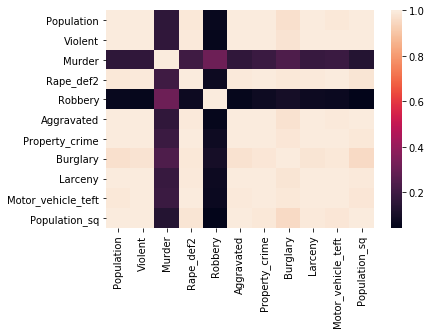

In [8]:
sns.heatmap(NY_crime_2013.corr())

There is high collinearity in the data. we will use pca to reduce it before building the model 

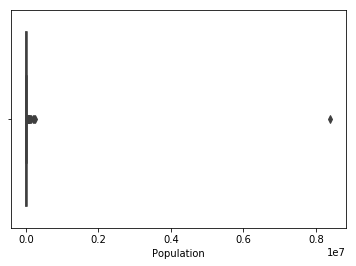

In [9]:
sns.boxplot(x=NY_crime_2013['Population'])

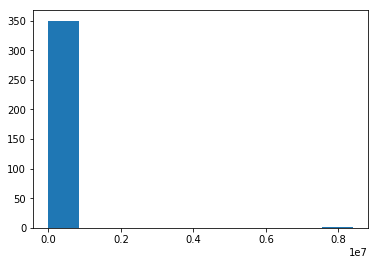

In [10]:
plt.hist(NY_crime_2013['Population'])
plt.show()

In [11]:
NY_crime_2013['Population'].describe()

count    3.510000e+02
mean     3.975725e+04
std      4.481147e+05
min      5.260000e+02
25%      3.010500e+03
50%      7.233500e+03
75%      1.816050e+04
max      8.396126e+06
Name: Population, dtype: float64

The graphs above and table above show outliers in the population column due to few places in the state such as New York city with high population. We'll exclude the upper quirtile using a bolean method 

In [12]:
lower_bound = 0
upper_bound = .75
data_range = NY_crime_2013.Population.quantile([lower_bound, upper_bound])
data_range 

0.00      526.0
0.75    18160.5
Name: Population, dtype: float64

In [13]:
true_index = (NY_crime_2013['Population'].values < data_range.loc[upper_bound])


In [14]:
false_index = ~true_index


In [15]:
NY_crime_2013['Population'] = NY_crime_2013['Population'][true_index]

In [18]:
NY_crime_2013 = NY_crime_2013[['Population','Violent', 'Murder', 'Rape_def2', 'Robbery', 'Property_crime', 'Burglary']].dropna()


In [19]:
NY_crime_2013.shape

(263, 7)

In [20]:
# Extract dependent and independent variables and create a data set with only the features we need 
x13 = NY_crime_2013[['Population','Violent', 'Murder', 'Rape_def2', 'Robbery', 'Burglary']]

x13.head()

,Population,Violent,Murder,Rape_def2,Robbery,Burglary
0,1861.0,0.0,0,0.0,0,2.0
1,2577.0,3.0,0,0.0,0,3.0
2,2846.0,3.0,0,0.0,0,1.0
4,6388.0,23.0,0,3.0,1,53.0
5,4089.0,5.0,0,0.0,1,10.0


In [25]:
# This is the variable we want to predict for the 2013 data set
y13 = NY_crime_2013['Property_crime']#[:263]

In [23]:
y13.describe()

count    263.000000
mean     118.180608
std      139.052357
min        0.000000
25%       29.500000
50%       66.000000
75%      153.500000
max      949.000000
Name: Property_crime, dtype: float64

### Validation data

Prepare validation data from another year (2014) tha same way. 

In [26]:
# Load and prepare the second data set for validation (crime rate in New York state in other year(2014)) 
NY_crime_2014 = pd.read_excel("Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls", header=None, skiprows=5)


In [27]:
NY_crime_2014.columns = ['City', 'Population', 'Violent', 'Murder', 'Rape_def1', 'Rape_def2', 'Robbery', 'Aggravated'
              , 'Property_crime', 'Burglary', 'Larceny', 'Motor_vehicle_teft', 'Arson']

In [28]:
# More cleanup and prep as the 2013 data set
NY_crime_2014['Robbery'] = (NY_crime_2014['Robbery'] > 0).astype(int)
NY_crime_2014['Murder'] = (NY_crime_2014['Murder'] > 0).astype(int)


In [29]:
NY_crime_2014['Population_sq'] = (NY_crime_2014['Population'] * NY_crime_2014['Population'])

In [30]:
# Replace the NaN value with the median. Too many to drop
NY_crime_2014 = NY_crime_2014.fillna(NY_crime_2014.median())

In [31]:
NY_crime_2014.shape

(376, 14)

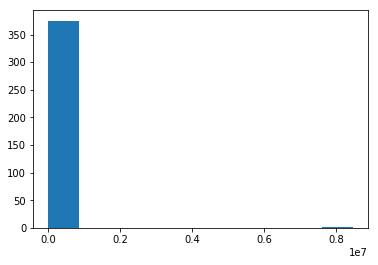

In [32]:
plt.hist(NY_crime_2014['Population'])
plt.show()

The data has outliers similar to the training data and will be cleaned by creating a boolean method to include only the .75 quartile 

In [33]:
# add 14 to the namings to indicate 2014 test data
lower_bound14 = 0
upper_bound14 = .75
data_range14 = NY_crime_2014.Population.quantile([lower_bound14, upper_bound14])
data_range14

0.00       79.00
0.75    15227.75
Name: Population, dtype: float64

In [34]:
true_index14 = (NY_crime_2014['Population'].values < data_range14.loc[upper_bound14])


In [35]:
false_index14 = ~true_index14


In [36]:
NY_crime_2014['Population'] = NY_crime_2014['Population'][true_index14]

In [37]:
NY_crime_2014.describe()

,Population,Violent,Murder,Rape_def1,Rape_def2,Robbery,Aggravated,Property_crime,Burglary,Larceny,Motor_vehicle_teft,Arson,Population_sq
count,282.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,3.760000e+02
mean,5278.453901,180.364362,0.135638,9.787234,0.002660,0.521277,109.976064,685.119681,99.244681,552.103723,33.715426,1.382979,1.918846e+11
std,3765.757976,2614.208973,0.342860,113.768103,0.051571,0.500213,1625.198220,7047.792797,847.170364,5807.354680,403.164339,7.880584,3.703152e+12
min,79.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.241000e+03
25%,2193.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,25.000000,4.000000,20.750000,0.000000,0.000000,7.194602e+06
50%,4081.500000,5.000000,0.000000,1.000000,0.000000,1.000000,3.000000,76.000000,12.000000,60.500000,2.000000,0.000000,4.330956e+07
75%,7736.500000,17.000000,0.000000,2.000000,0.000000,1.000000,12.000000,266.500000,38.250000,222.250000,6.000000,1.000000,2.318844e+08
max,15223.000000,50564.000000,1.000000,2190.000000,1.000000,1.000000,31460.000000,135747.000000,15916.000000,112107.000000,7724.000000,135.000000,7.180763e+13


In [38]:
NY_crime_2014 = NY_crime_2014[['Population','Violent', 'Murder', 'Rape_def2', 'Robbery', 'Property_crime', 'Burglary']].dropna()


In [39]:
x14 = NY_crime_2014[['Population','Violent', 'Murder', 'Rape_def2', 'Robbery', 'Burglary']]
x14.head()

,Population,Violent,Murder,Rape_def2,Robbery,Burglary
0,1851.0,0.0,0,0.0,0,1.0
1,2568.0,2.0,0,0.0,1,1.0
2,820.0,0.0,0,0.0,0,0.0
3,2842.0,1.0,0,0.0,0,0.0
5,5872.0,26.0,0,0.0,1,41.0


In [40]:
x14.describe()

,Population,Violent,Murder,Rape_def2,Robbery,Burglary
count,282.000000,282.000000,282.000000,282.0,282.000000,282.000000
mean,5278.453901,6.510638,0.035461,0.0,0.375887,13.716312
std,3765.757976,10.915474,0.185271,0.0,0.485212,18.976789
min,79.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,2193.000000,0.000000,0.000000,0.0,0.000000,2.250000
50%,4081.500000,2.000000,0.000000,0.0,0.000000,8.000000
75%,7736.500000,7.750000,0.000000,0.0,1.000000,16.000000
max,15223.000000,75.000000,1.000000,0.0,1.000000,132.000000


In [41]:
# we'll try to predict this value for validation. 
# set the length similar to x14 to avoid errors 
y14 = NY_crime_2014['Property_crime'][:282]#.values.reshape(1, -1)



In [42]:
y14.describe()

count     282.00000
mean       87.48227
std       120.48683
min         0.00000
25%        17.00000
50%        46.50000
75%       107.50000
max      1090.00000
Name: Property_crime, dtype: float64

## The Model

In [47]:
# standardize in preparation for pca (2013 data set)
X_nor = StandardScaler().fit_transform(x13)

In [43]:
# standardize 2014 data
X_nor14 = StandardScaler().fit_transform(x14)

In [44]:
pca =PCA(n_components=4)

In [45]:
X_reg14 = pca.fit_transform(X_nor14)
print(pca.explained_variance_ratio_)

[0.57794023 0.18968493 0.10994219 0.09300199]


In [48]:
X_reg = pca.fit_transform(X_nor)
print(pca.explained_variance_ratio_)

[0.58760043 0.13915154 0.12337783 0.08677217]


In [49]:
# use holdout group to test the model on the 2013 data 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_reg, y13, test_size = 0.2, random_state = 0)

In [51]:
# fit the 2013 data
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [57]:
# fluctuation in the score suggests overfitting in the data 
from sklearn.model_selection import cross_val_score
score = cross_val_score(regressor, X_reg, y13, cv=4)
print(score)

[0.85344191 0.80012155 0.75493515 0.48117839]


In [58]:
y_pred = regressor.predict(x_test)


In [59]:
# calculate the R squered value
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.6839329450230911

In [60]:
print('MSE:', mean_squared_error(y_test, y_pred))

MSE: 5645.501520771094


### Validate with 2013 

In [62]:
# predicting for property crime in 2014 using the model 
y_pred14 = regressor.predict(X_reg14)


In [63]:
# less fluctuation compared to the 2013 data 
from sklearn.model_selection import cross_val_score
score14 = cross_val_score(regressor, X_reg14, y14, cv=4)
print(score14)

[0.79773765 0.70531423 0.65253762 0.67908519]


In [64]:
# calculate the R squered value
from sklearn.metrics import r2_score
r2_score(y14, y_pred14)

0.6670095568984615

In [65]:
print('MSE:', mean_squared_error(y14, y_pred14))

MSE: 4816.905622475219


The model returns relatively closer values for both data sets 

### Check for homoscedassticity 

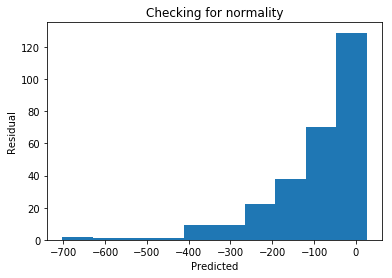

In [66]:
# Normality test
actual = y14
predicted = y_pred14
residual = actual[len(predicted)] - predicted # length of actual is different from
# predicted because of the holdout split
plt.hist(residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Checking for normality')
plt.show()

In [67]:
# try get square roots of data points
sqrt_y14 = y14.apply(np.sqrt)

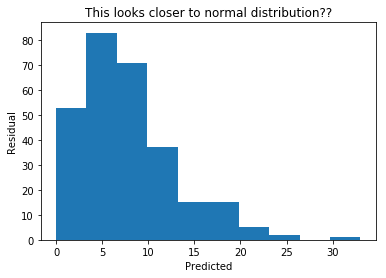

In [69]:
plt.hist(sqrt_y14)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('This looks closer to normal distribution??')
plt.show()

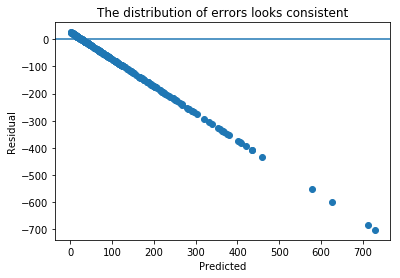

In [70]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('The distribution of errors looks consistent')
plt.show()

### In conclusion 

The model seems to show little difference in the performance indicators for both data sets. The cross validation shows a lot of fluctuation and that could be due to overfitting in the data. Over all it can be concluded that the model has a predictive validity.  